# GEOG696C Spatiotemporal Data Analytics: Term Project
## calcEOF_precip.ipynb
This script reads in the precip data - extracted in the code "extractPrecipTimeSeries.ipynb" - and performs EOF and rotated EOF, with significance testing.

In [86]:
from pathlib import Path
import os
import sys
import pandas as pd
import numpy as np
import math
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import rioxarray as rx
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import scipy as sp
import cartopy
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
import calendar
from matplotlib import gridspec
from matplotlib.ticker import FuncFormatter

In [2]:
# Set the root path
# rootPath = Path('/media/mule/Projects/NASA/NIP/Data')
rootPath = Path('C:/Users/alexsaunders/Documents/01_uoa/01_study/2023/geog696c/project/data')

In [3]:
font_dirs = ['C:/users/alexsaunders/appdata/local/microsoft/windows/fonts']
font_files = mpl.font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    mpl.font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Work Sans'

## 1) Load the precip data with xarray
Pentad timesteps from 2000-2022 (ntime=1584)

In [5]:
chirpsPath=rootPath/'chirps'
rawPath=chirpsPath/'raw'

In [6]:
# Open the pentad data
precip = pd.read_csv(rawPath/'precipPentad.csv', index_col=0)

In [7]:
# Open the time and coords reference data
coords = pd.read_csv(rawPath/'precipCoords.csv')
times = pd.read_csv(rawPath/'precipPentadDates.csv')
times=times[['0']]
times.columns=['time']
coords=coords[['lat','lon']]
coords.columns=['lon','lat']
times=pd.to_datetime(times.time)

In [8]:
# Define the dimensions
ntime, nloc = precip.shape
nrow, ncol = len(np.unique(coords.lat)), len(np.unique(coords.lon))
nlocsTotal = len(np.unique(coords.lon))* len(np.unique(coords.lat))

In [9]:
# Create a coords frame for the entire rectangle area, then note which locations are missing data
lats=[]
lons=[]
for la in np.sort(np.unique(coords.lat))[::-1]:
    for lo in np.sort(np.unique(coords.lon)):
        lats.append(la)
        lons.append(lo)

In [10]:
# Check if loc exists in data otherwise mark as missing loc to be filled with nan
coords['lo_la']= [str(coords.lat[i])+'_'+str(coords.lon[i]) for i in range(len(coords))]
missingLocs=[]
validLocs=[]
for i, la in enumerate(lats):
    lo = lons[i]
    la_lo = str(la)+'_'+str(lo)
    if coords['lo_la'].str.contains(la_lo).sum()==0:
        missingLocs.append(i)
    if coords['lo_la'].str.contains(la_lo).sum()>0:
        validLocs.append(i)

In [11]:
# Create new precip array icluding no data points
precip.columns=validLocs
precip2D=np.ones([ntime, nlocsTotal])*np.nan
for i in range(nlocsTotal):
    if i in validLocs:
        precip2D[:,i]=np.array(precip[[i]]).squeeze()

In [12]:
# Reshape the precip data from 2D to 3D
precip3D = np.reshape(precip2D, [ntime, nrow, ncol])#, order='F')
print(precip3D.shape) # time, lat (from north to south), lon (from W to E)

(1584, 120, 93)


In [13]:
# Convert to xarray data array
latitude=np.sort(np.unique(coords.lat))[::-1]
longitude=np.unique(coords.lon)
precipxr = xr.DataArray(
    precip3D,
    coords={'time': times, 'lat': latitude, 'lon': longitude},
    dims=['time', 'lat', 'lon']
)

### Quick plot for sanity check
Looks good!

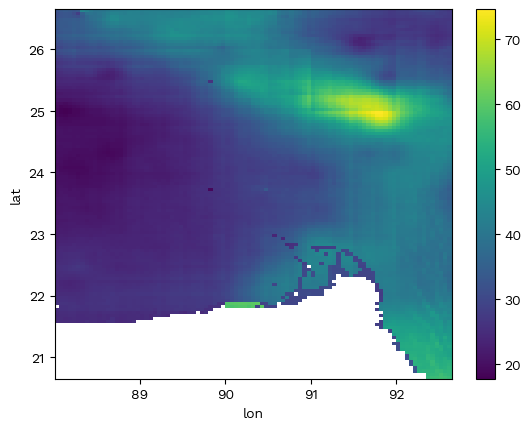

In [14]:
precipxr.mean(dim="time").plot()

In [144]:
# Save as a netcdf for ease of loading in again later
outPath= chirpsPath/'xr'
outPath.mkdir(exist_ok=True)
precipxr.to_netcdf(outPath/'precip.nc')

In [15]:
precipxr

<xarray.DataArray (time: 1584, lat: 120, lon: 93)>
array([[[1.47254145, 1.37144387, 1.35187316, ..., 1.24580288,
         1.35831702, 1.27305031],
        [1.22709835, 1.27960563, 1.33862114, ..., 1.2185303 ,
         1.3001374 , 1.25125098],
        [0.9589172 , 1.1880554 , 1.35091472, ..., 1.29320931,
         1.17814088, 1.14068198],
        ...,
        [       nan,        nan,        nan, ..., 0.62495655,
         0.60795516, 0.60766745],
        [       nan,        nan,        nan, ..., 0.72611147,
         0.65807641, 0.65274197],
        [       nan,        nan,        nan, ..., 0.79969203,
         0.7062248 , 0.68635577]],

       [[1.13506746, 1.03916299, 1.01685953, ..., 1.22699451,
         1.32619941, 1.25027943],
        [0.85221988, 0.9020375 , 0.97864771, ..., 1.2109344 ,
         1.29625821, 1.24461508],
        [0.58917737, 0.81461585, 0.98276025, ..., 1.33240747,
         1.15452886, 1.12378895],
...
        [       nan,        nan,        nan, ..., 0.77742928,
         0.75702292, 0.75704044],
        [       nan,        nan,        nan, ..., 0.77492309,
         0.75151944, 0.76295048],
        [       nan,        nan,        nan, ..., 0.9883287 ,
         0.76336682, 0.80978364]],

       [[0.49113142, 0.51429278, 0.49193454, ..., 1.66854334,
         1.76067472, 1.6578753 ],
        [0.56999964, 0.56664574, 0.51286936, ..., 1.55828846,
         1.63981938, 1.62351418],
        [0.62451667, 0.57210141, 0.52004701, ..., 1.76764917,
         1.66249108, 1.59791875],
        ...,
        [       nan,        nan,        nan, ..., 1.51700163,
         1.43748236, 1.40950358],
        [       nan,        nan,        nan, ..., 1.366588  ,
         1.33323276, 1.34068978],
        [       nan,        nan,        nan, ..., 1.86442614,
         1.39508057, 1.44921279]]])
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 2001-01-06 ... 2022-12-26
  * lat      (lat) float64 26.62 26.57 26.52 26.47 ... 20.82 20.77 20.72 20.67
  * lon      (lon) float64 88.03 88.08 88.13 88.18 ... 92.48 92.53 92.58 92.63

### Plot the monthly precipitation averages

In [24]:
# Function to get the extend argument
def getExtend(amin, amax, vmin, vmax):
    if amin<vmin and amax<=vmax:
        extend='min'
    elif amax>vmax and amin>=vmin:
        extend='max'
    elif amin<vmin and amax>vmax:
        extend='both'
    else:
        extend='neither'
    return extend

In [16]:
# precipMonthlyClim = precipxr.groupby('time.month').mean(dim='time')

In [51]:
precipMonthlySum=precipxr.resample(time='1M', skipna=True).sum(dim='time')
precipMonthlyClim = precipMonthlySum.groupby('time.month').mean(dim='time')

In [22]:
monthNames=[item[:3] for item in list(calendar.month_name)[1:]]

In [58]:
precipMonthlyClim.sum(dim=["lat", "lon"])

<xarray.DataArray (month: 12)>
array([  86418.73430565,  153762.23608809,  438043.78901798,
       1377523.24558243, 2800029.9389307 , 4318056.39098957,
       4652798.69439813, 3751244.8210242 , 3117428.27609299,
       1819404.24136816,  183889.34297792,   63524.22454044])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

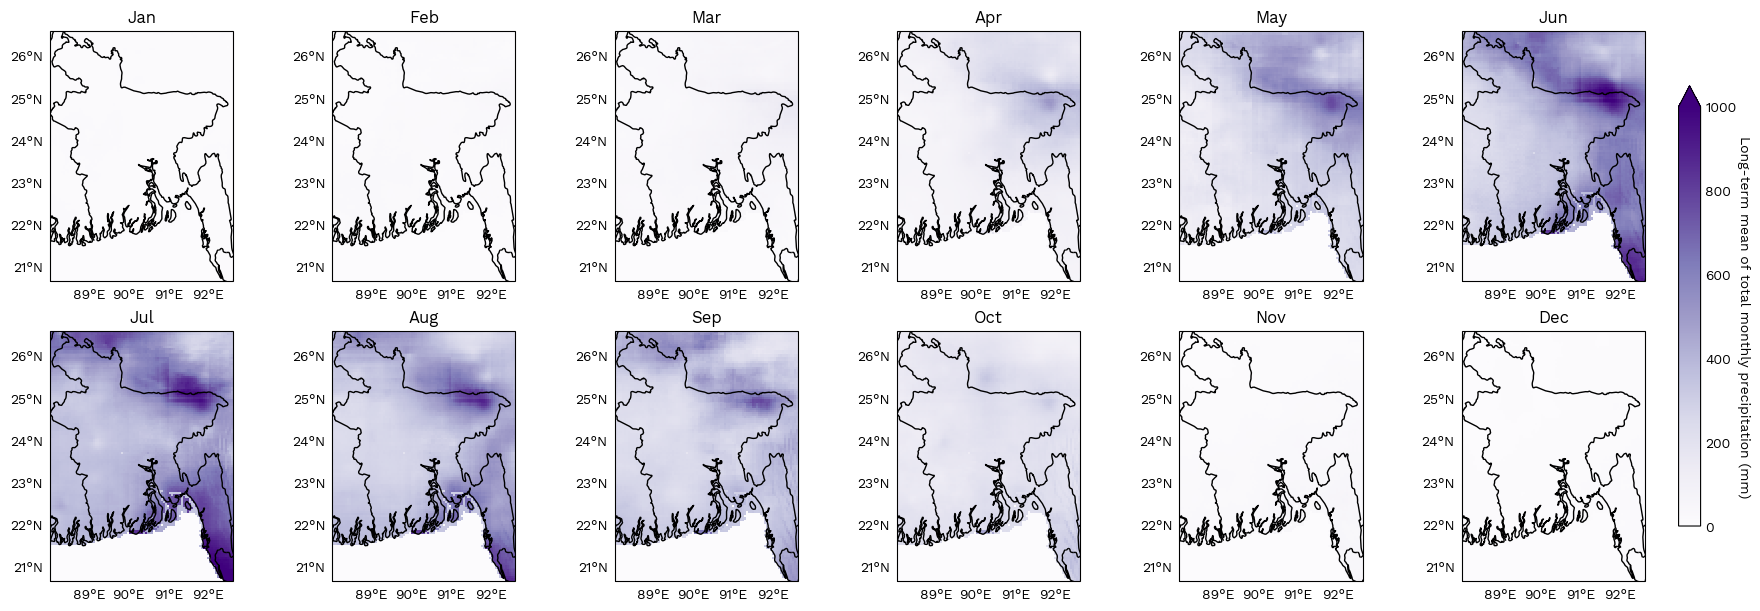

In [55]:
# Define arguments for plotting
plotData=precipMonthlyClim
coordsData=precipMonthlyClim
vmin, vmax, nlevelsCbar = 0, 1000, 6
amin, amax = np.nanmin(plotData), np.nanmax(plotData)
extend=getExtend(amin, amax, vmin, vmax)
cmap='Purples'
# levels = np.linspace(vmin, vmax, nlevels)
nToPlot=12
ncolsToPlot=6
nrowsToPlot=math.ceil(nToPlot/ncolsToPlot)
colSize=3
extentBuffer=0
plotExtent= [coordsData.lon.min().values - extentBuffer, coordsData.lon.max().values + extentBuffer, coordsData.lat.min().values - extentBuffer, coordsData.lat.max().values + extentBuffer]
centerLon = 90

# Create time series of country totals for subplot - use subfigs to plot below maps
tsData = plotData.sum(dim=["lat", "lon"])

# Plot
fig, axes = plt.subplots(nrowsToPlot, ncolsToPlot, figsize=(colSize*ncolsToPlot, colSize*nrowsToPlot), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=centerLon)})

for i, ax in enumerate(axes.ravel()):   
    ax.coastlines(color='black') 
    # ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.BORDERS)
    ax.set_extent(plotExtent, crs=ccrs.PlateCarree())
    gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                      y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
    gl1.xlines=False
    gl1.ylines=False
    axplot = plotData[i,:,:].plot.imshow(ax=ax, cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, add_colorbar=False, extend=extend)#, levels=levels
    ax.set_title('{0}'.format(monthNames[i]))#, fontsize=16)
    # cb1 = plt.colorbar(axplot, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar), shrink=0.8, extend=extend)
    # cb1.ax.tick_params(size=0)        
cb = fig.colorbar(axplot, ax=axes.ravel().tolist(), orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar), shrink=0.8, extend=extend, pad=0.02)
cb.ax.tick_params(size=0)
cb.set_label('Long-term mean of total monthly precipitation (mm)', rotation=270, labelpad=10)
plt.show()

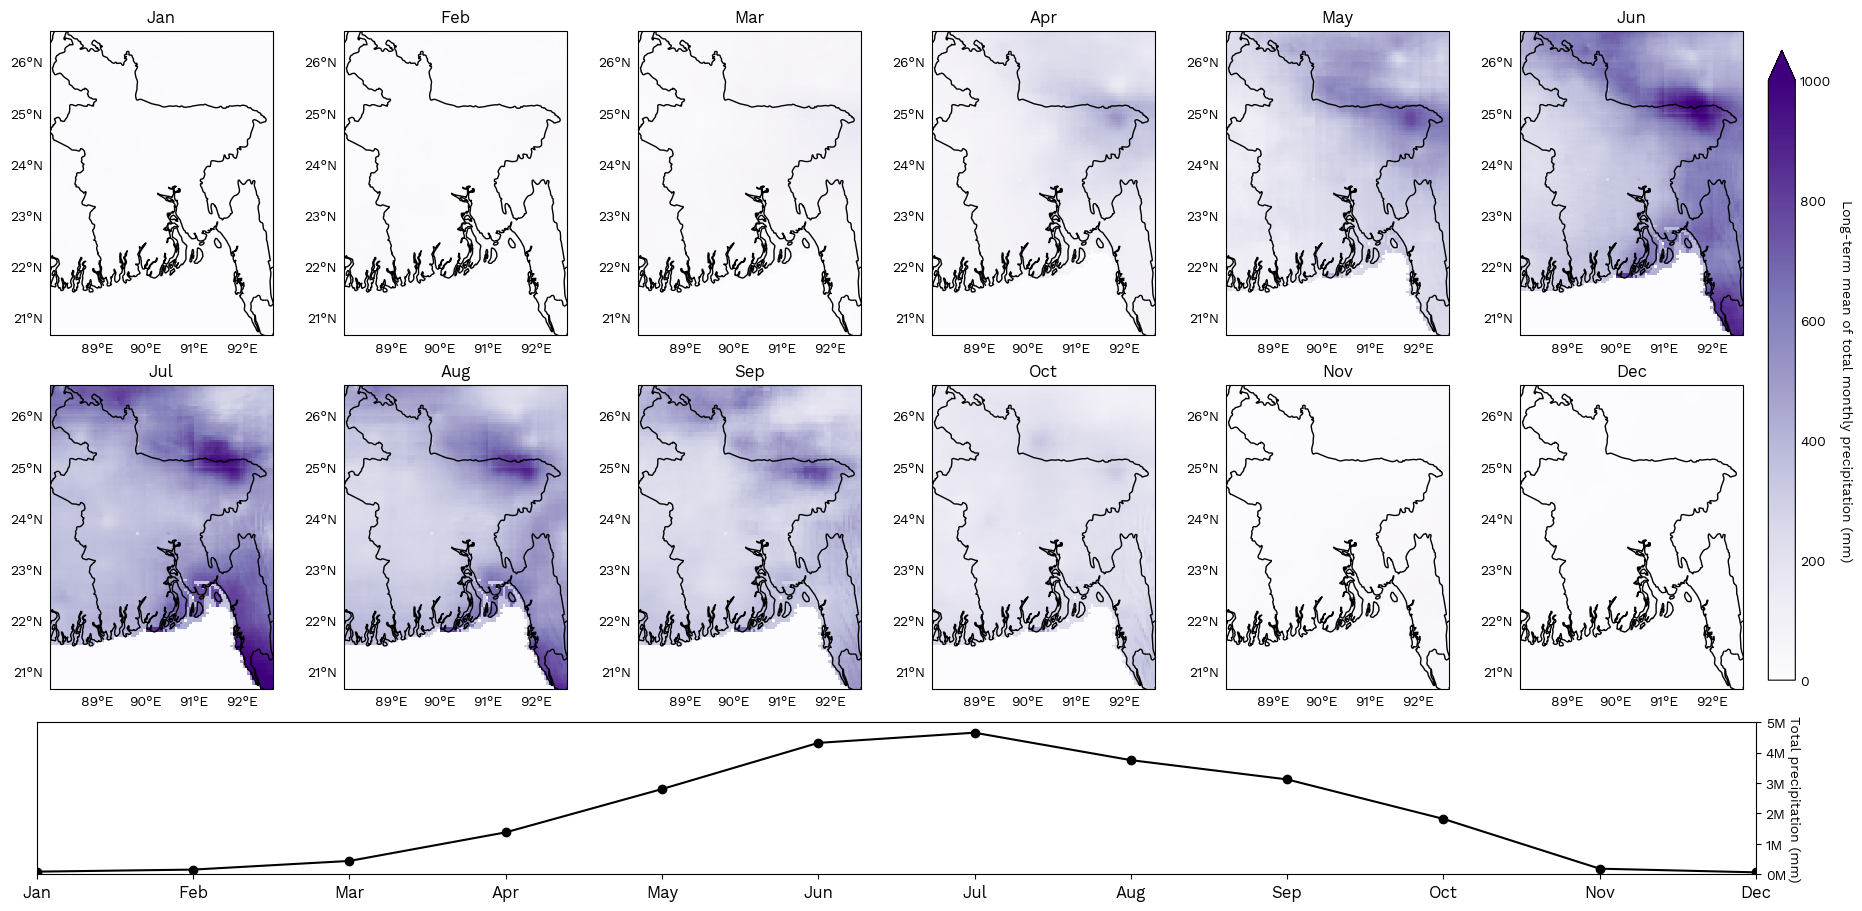

In [90]:
# Define arguments for plotting
plotData=precipMonthlyClim
coordsData=precipMonthlyClim
vmin, vmax, nlevelsCbar = 0, 1000, 6
amin, amax = np.nanmin(plotData), np.nanmax(plotData)
extend=getExtend(amin, amax, vmin, vmax)
cmap='Purples'
# levels = np.linspace(vmin, vmax, nlevels)
nToPlot=12
ncolsToPlot=6
nrowsToPlot=math.ceil(nToPlot/ncolsToPlot) + 1 # add one for the time series below
colSize=3
extentBuffer=0
plotExtent= [coordsData.lon.min().values - extentBuffer, coordsData.lon.max().values + extentBuffer, coordsData.lat.min().values - extentBuffer, coordsData.lat.max().values + extentBuffer]
centerLon = 90

# Create time series of country totals for subplot - use gridspec to plot below maps
tsData = plotData.sum(dim=["lat", "lon"])

# # Plot
# fig = plt.figure(constrained_layout=True)
# subfigs = fig.subfigures(2, 1, height_ratios=[3, 1])

# Create a figure with a grid layout
fig = plt.figure(figsize=(colSize*ncolsToPlot, colSize*nrowsToPlot), constrained_layout=True)
gs = gridspec.GridSpec(nrowsToPlot, ncolsToPlot, figure=fig, height_ratios=[2, 2, 1], width_ratios=[1, 1, 1, 1, 1, 1])

# Plot the 12 maps
for i in range(nToPlot):
    row = i // 6
    col = i % 6
    ax = plt.subplot(gs[row, col], projection=ccrs.Miller(central_longitude=centerLon)) #subplot_kw={'projection': ccrs.Miller(central_longitude=centerLon)}
    ax.coastlines(color='black') 
    # ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.BORDERS)
    ax.set_extent(plotExtent, crs=ccrs.PlateCarree())
    gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                      y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
    gl1.xlines=False
    gl1.ylines=False
    axplot = plotData[i,:,:].plot.imshow(ax=ax, cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, add_colorbar=False, extend=extend)#, levels=levels
    ax.set_title('{0}'.format(monthNames[i]))#, fontsize=16)
    # cb1 = plt.colorbar(axplot, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar), shrink=0.8, extend=extend)
    # cb1.ax.tick_params(size=0)        
# cb = fig.colorbar(axplot, ax=axes.ravel().tolist(), orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar), shrink=0.8, extend=extend, pad=0.02)
# cb.ax.tick_params(size=0)
# cb.set_label('Long-term mean of total monthly precipitation (mm)', rotation=270, labelpad=10)

# Create a subplot for the time series beneath the maps
ax_ts = plt.subplot(gs[2, :])
ax_ts.plot(tsData, 'ko-', zorder=2)
ax_ts.set_xlim(0,11)
ax_ts.set_ylim(0,5e6)
ax_ts.yaxis.tick_right()
ax_ts.yaxis.set_label_position("right")
ax_ts.set_ylabel('Total precipitation (mm)', rotation=270, labelpad=10) 
ax_ts.tick_params(axis='y', which='both', left=False, right=True)
formatter = FuncFormatter(lambda x, _: '{:.0f}M'.format(x * 1e-6))
ax_ts.yaxis.set_major_formatter(formatter)
ax_ts.set_xticks(range(nToPlot),monthNames, fontsize=12) 

# Add single cbar
cbar_ax = fig.add_axes([0.98, 0.25, 0.015, 0.7]) 
cb = fig.colorbar(axplot, cax=cbar_ax, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar), shrink=0.8, extend=extend, pad=0.02)
cb.ax.tick_params(size=0)
cb.set_label('Long-term mean of total monthly precipitation (mm)', rotation=270, labelpad=15)

plt.show()

## Compute EOF on annual maximum

In [145]:
# Use resample to get annual
precipAnnualMax = precipxr.resample(time='1Y', skipna=True).max(dim='time')

### Quick plots of annual max

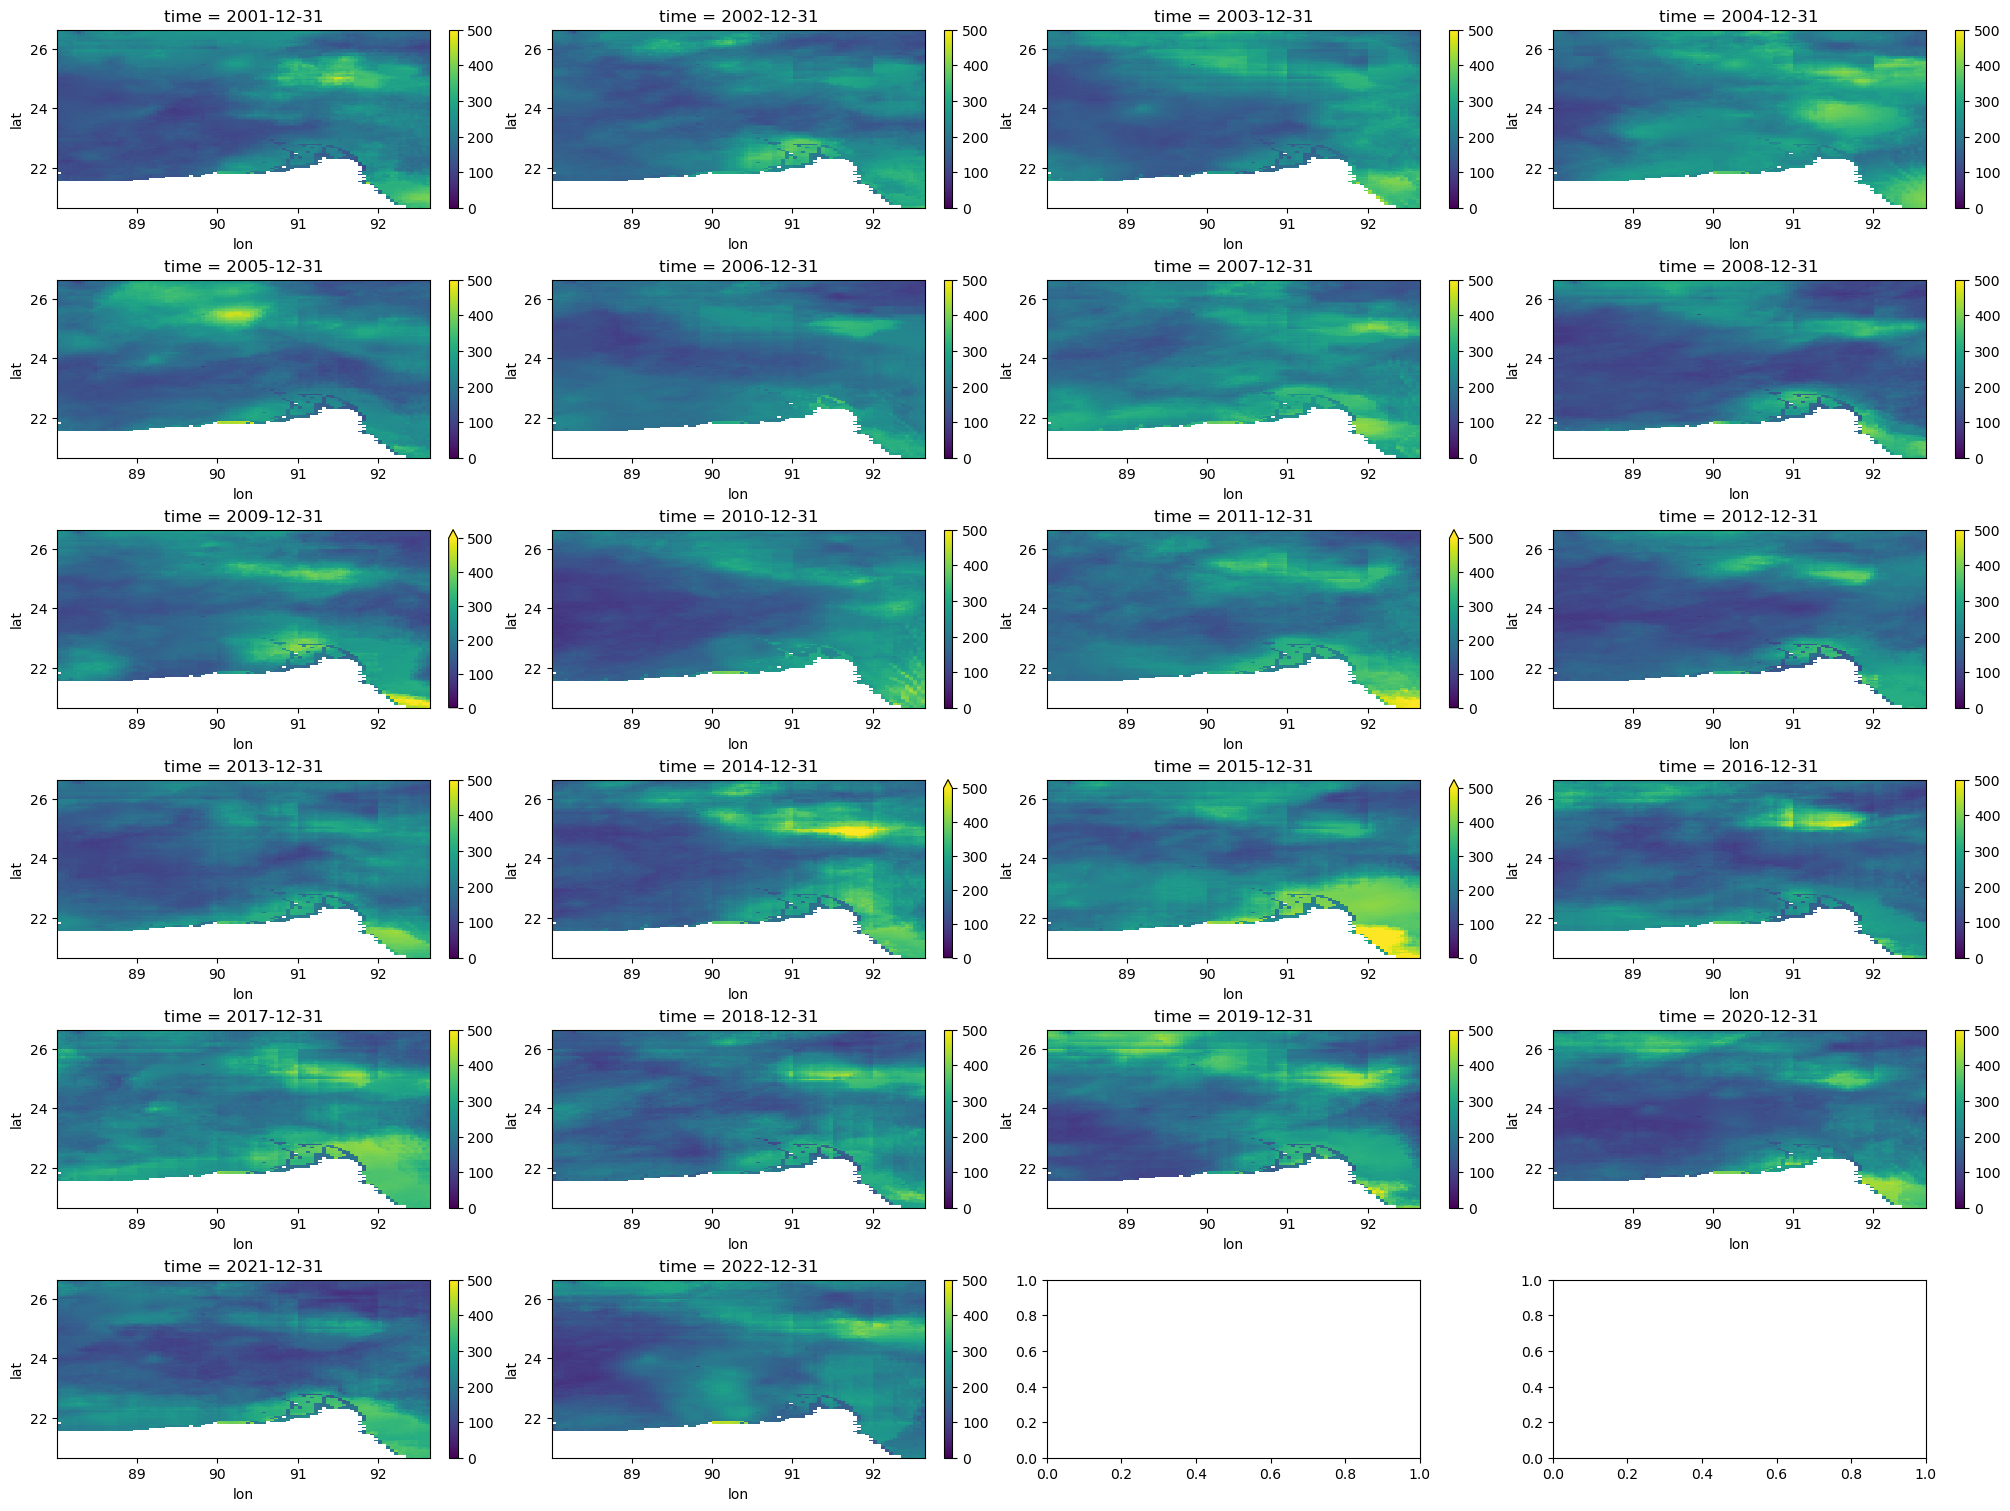

In [156]:
fig, axes = plt.subplots(6,4, figsize=(20,15), constrained_layout=True)

for i, ax in enumerate(axes.ravel()[0:len(precipAnnualMax.time)]):
    precipAnnualMax[i,:,:].plot(ax=ax, vmin=0, vmax=500)

### Reshape and normalize

In [285]:
# Function to reshape, remove locs with missing values
def reshape(data):
    ntime, nrow, ncol = data.shape
    nloc=nrow*ncol
    dataNew = np.array(data).reshape(ntime, nloc)
    print('Shape before removing data with missing vals', dataNew.shape)
    # Remove locs with missing values i.e. only keep pixels which have zero NA values at all timesteps
    noMissing = ~np.isnan(dataNew).any(axis=0)
    dataNew = dataNew[:,noMissing]
    print('Shape after removing data with missing vals', dataNew.shape)
    return dataNew, ntime, nrow, ncol, nloc, noMissing

In [286]:
precipAnnualMax2D, ntime, nrow, ncol, nloc, noMissing = reshape(precipAnnualMax)

Shape before removing data with missing vals (22, 11160)
Shape before removing data with missing vals (22, 9317)


In [287]:
# Function to normalize - subtract mean and divide by standard deviation at each pixel
def normalize(data):
    anom = (data - data.mean(axis=0)) / data.std(axis=0)
    return anom

In [288]:
precipAnnualMaxAnom = normalize(precipAnnualMax2D)

In [289]:
precipAnnualMaxAnom[0,:]

array([ 0.55329358,  0.55739635,  0.49202177, ..., -0.29978521,
       -0.14219201,  0.02005767])

### Perform EOF

In [324]:
# Function to perform EOF
def getEOF(dataAnom, k, nrow, ncol, noMissing):
    U, S, Vt = sp.sparse.linalg.svds(dataAnom, k=k)
    # Sort the eigenmodes
    sort_index = np.argsort(S)[::-1]
    S = S[sort_index]
    U = U[:,sort_index]
    V = Vt.T[:,sort_index]
    # Create the PCs time series
    pcs = dataAnom @ V
    # Create the EOFs with dimensions of the original data
    eofs = np.full((nrow*ncol, S.shape[0]), np.nan) 
    eofs[noMissing,:] = V
    eofs = eofs.reshape([nrow, ncol, S.shape[0]])
    print('EOFs',eofs.shape)
    print('PCs',pcs.shape)
    return eofs, pcs, S, U, V

In [325]:
eofs, pcs, S, U, V = getEOF(precipAnnualMaxAnom, 21, nrow, ncol, noMissing)

EOFs (120, 93, 21)
PCs (22, 21)


In [326]:
# Swap sign of the first EOF
eofs[:,:,0]=-eofs[:,:,0]
pcs[:,0]=-pcs[:,0]

In [307]:
precipAnnualMaxAnom.shape

(22, 9317)

### Perform EOF using correlation matrix, not original data

In [318]:
# Function to perform EOF, using correlation matrix - gives the same result, but eigenvalues in U rather than V
def getEOFonCorrelMat(C, k, nrow, ncol, noMissing):
    # Run SVD on the correlation matrix
    U,S,V= sp.sparse.linalg.svds(C,k=k)
    sort_index = np.argsort(S)[::-1] 
    S = S[sort_index] 
    U = U[:,sort_index]
    # Create the EOFs with dimensions of the original data
    eofs = np.full((nrow*ncol, S.shape[0]), np.nan) 
    eofs[noMissing,:] = U
    eofs = eofs.reshape([nrow, ncol, S.shape[0]])
    return eofs

In [320]:
C = np.corrcoef(precipAnnualMaxAnom,rowvar=False,ddof=1)
eofsC = getEOFonCorrelMat(C, 21, nrow, ncol, noMissing)

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_15772\2938533399.py:1: DeprecationWarning: bias and ddof have no effect and are deprecated
  C = np.corrcoef(precipAnnualMaxAnom,rowvar=False,ddof=1)


Okay, these are the same, that's good!

### Plot the EOFs

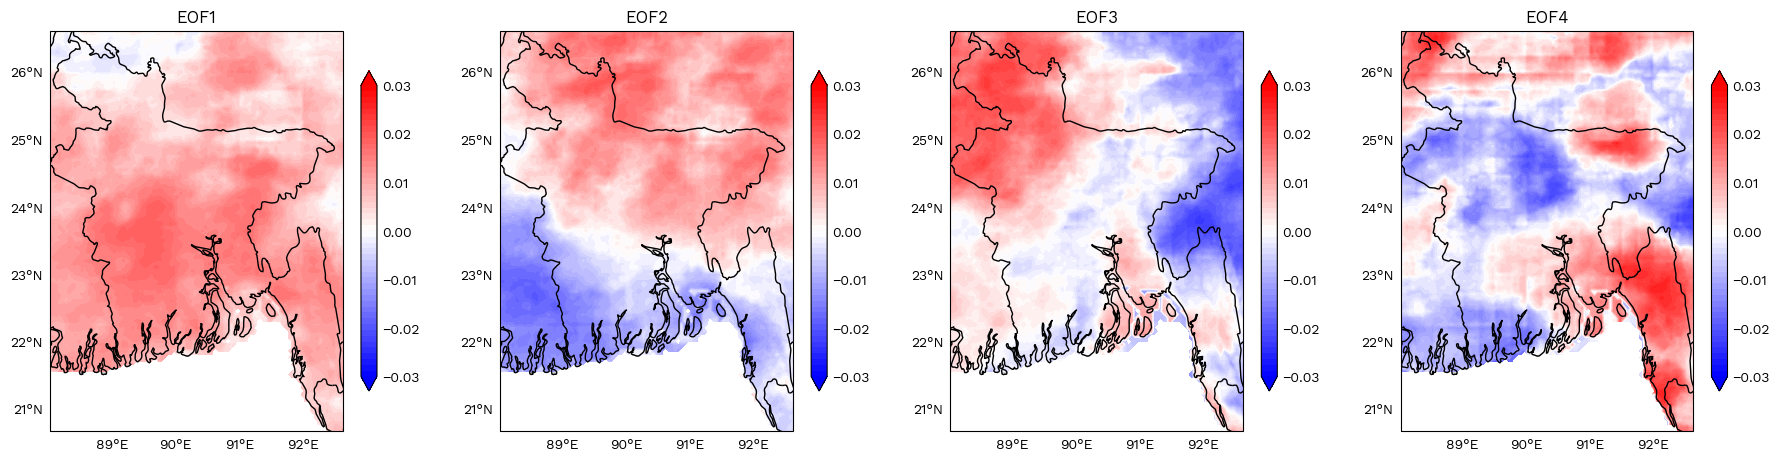

In [384]:
# Define data and arguments for plotting
plotData=eofs
coordsData=precipxr
titleName='EOF'
vmin, vmax, nlevels, nlevelsCbar = -0.03, 0.03, 51, 7
amin, amax = np.nanmin(plotData), np.nanmax(plotData)
extend=getExtend(amin, amax, vmin, vmax)
cmap='bwr'
levels = np.linspace(vmin, vmax, nlevels)
EOFsToPlot=4
ncolsToPlot=4
nrowsToPlot=math.ceil(EOFsToPlot/ncolsToPlot)
colSize=4.5
extentBuffer=0
plotExtent = [coordsData.lon.min().values - extentBuffer, coordsData.lon.max().values + extentBuffer, coordsData.lat.min().values - extentBuffer, coordsData.lat.max().values + extentBuffer]
centerLon = 90

# Plot
fig, axes = plt.subplots(nrowsToPlot, ncolsToPlot, figsize=(colSize*ncolsToPlot, colSize*nrowsToPlot), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=centerLon)})
# fig.suptitle('EOFs in Annual Max Precipitation, from CHIRPS 2001-2022')

for i, ax in enumerate(axes.ravel()):
    ax.set_title('{0}{1}'.format(titleName, i+1))#, fontsize=16)
    ax.coastlines(color='black') 
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.BORDERS)
    ax.set_extent(plotExtent, crs=ccrs.PlateCarree())
    gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                      y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
    gl1.xlines=False
    gl1.ylines=False
    eofPlot = ax.contourf(coordsData.lon, coordsData.lat, plotData[:,:,i], cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, levels=levels, extend=extend) 
    cb1 = plt.colorbar(eofPlot, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar), shrink=0.8)
    cb1.ax.tick_params(size=0)

### Plot the PCs

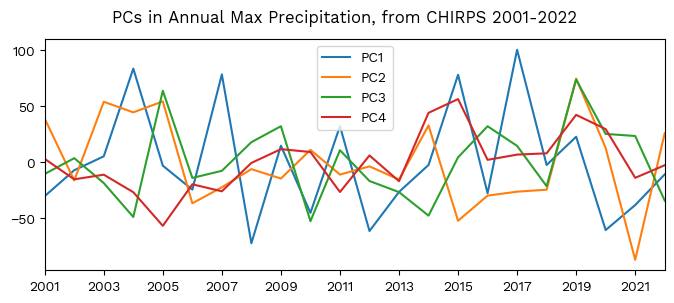

In [298]:
years=[pd.to_datetime(item).year for item in precipAnnualMax.time.values]
fig, ax = plt.subplots(figsize=(8,3))
fig.suptitle('PCs in Annual Max Precipitation, from CHIRPS 2001-2022')

for i in range(4):
    ax.plot(years, pcs[:,i], label='PC{}'.format(i+1))
    
ax.set_xlim(min(years), max(years))
ax.set_xticks(range(min(years), max(years), 2), range(min(years), max(years), 2))
ax.legend()

plt.show()

## Perform rotated EOF

In [332]:
def varimax_rotation(A, reltol=1e-9, itermax=1000, normalize=False):
    # following Lawley and Maxwell (1962)
  
    if normalize: # this is the 'Kaiser normalization', not the pre-normalization we were talking about above
        h = np.sqrt(np.sum(A**2, axis=1))
        A = A / h[:, np.newaxis]

    # get the size of the selected eigenvectors matrix
    nrows, ncol = A.shape
    
    # set the gamma value for varimax
    gamma = 1.0 
    
    # this is the initial rotation matrix, T, which starts simply as the identity matrix
    T = np.eye(ncol) 
    
    # first 'rotation' is just the dot product of the loadings and the identity matrix
    B = np.dot(A, T) 
    
    var_new = 0
    converged = False

    for k in range(1, itermax + 1): # iterations can be up to itermax
        
        # set the prior variance to the previous step
        var_prior = var_new
        
        # svd of the dot product of the unroated EOFs and the variance of the squared loadings of the current REOF 
        U, S, V = np.linalg.svd(np.dot(A.T, (nrows * B**3 - gamma * B @ np.diag(np.sum(B**2, axis=0)))))
        
        # recalculate the rotation matrix as the dot product of the eigenvectors 
        T = np.dot(U, V)
        
        # the new variance metric is the sum of the diagonals of S
        var_new = np.sum(S)
        
        # recalculate the REOFs as the dot product of the EOFs and new rotation matrix
        B = np.dot(A, T)
        
        # if we are now below the relative tolerance, exit and report the values
        if abs(var_new - var_prior) / var_new < reltol:
            break
    
    # Unnormalize the rotated loadings if necessary
    if normalize:
        B = B * h[:, np.newaxis]
    
    return B, T

In [338]:
# set the number of eigenvectors to rotate
numberToRotate = 21 

# create a subset of the eigenvectors and put them in the array called A
A = V[:,0:numberToRotate] 

## EOF pre-scaling

# option 1, no scaling - returns REOFs that are orthogonal but time series will now be correlated - Mestes-Nunez (2000) calls this 'EOF mode'
# A = A

# option 2, multiply by the square root of the eigenvalues - Mestes-Nunez (2000) calls this 'PCA mode' = preserves neither characteristic
A = A * np.sqrt(S[0:numberToRotate])  

# option 3, divide by the square root of the eigenvalues - signals remain uncorrelated - this is 'an unusual case' as Mestes-Nunez (2000) says
# A = A / np.sqrt(S[0:numberToRotate]) 

# run our internal function for varimax rotation on the selected scaled EOFs:
reofs2D, rotation_matrix = varimax_rotation(A,normalize=True)

# Reshape REOFs
reofs = np.full((nrow*ncol, numberToRotate), np.nan) 
reofs[noMissing,:] = reofs2D
reofs = reofs.reshape([nrow, ncol, numberToRotate])

In [343]:
# Reverse the sign of the first REOF
reofs[:,:,0]=-reofs[:,:,0]

### Plot the REOFs

In [339]:
reofs.shape

(120, 93, 21)

In [344]:
print(np.nanmin(reofs), np.nanmax(reofs))

-0.4791765280383072 0.5118563878413445


In [383]:
# Function to get the extend argument
def getExtend(amin, amax, vmin, vmax):
    if amin<vmin and amax<=vmax:
        extend='min'
    elif amax>vmax and amin>=vmin:
        extend='max'
    elif amin<vmin and amax>vmax:
        extend='both'
    else:
        extend='neither'
    return extend

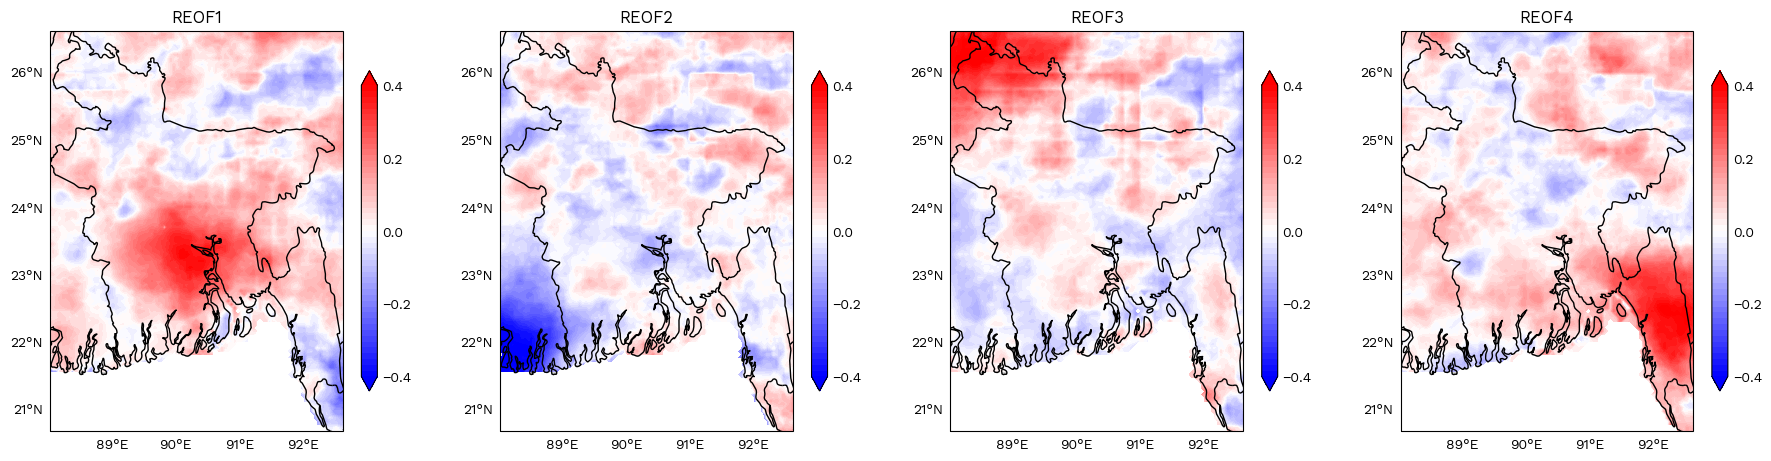

In [385]:
# Define data and arguments for plotting
plotData=reofs
coordsData=precipxr
titleName='REOF'
vmin, vmax, nlevels, nlevelsCbar = -0.4, 0.4, 51, 5
amin, amax = np.nanmin(plotData), np.nanmax(plotData)
extend=getExtend(amin, amax, vmin, vmax)
cmap='bwr'
levels = np.linspace(vmin, vmax, nlevels)
EOFsToPlot=4
ncolsToPlot=4
nrowsToPlot=math.ceil(EOFsToPlot/ncolsToPlot)
colSize=4.5
extentBuffer=0
plotExtent = [coordsData.lon.min().values - extentBuffer, coordsData.lon.max().values + extentBuffer, coordsData.lat.min().values - extentBuffer, coordsData.lat.max().values + extentBuffer]
centerLon = 90

# Plot
fig, axes = plt.subplots(nrowsToPlot, ncolsToPlot, figsize=(colSize*ncolsToPlot, colSize*nrowsToPlot), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=centerLon)})
# fig.suptitle('EOFs in Annual Max Precipitation, from CHIRPS 2001-2022')

for i, ax in enumerate(axes.ravel()):
    ax.set_title('{0}{1}'.format(titleName, i+1))#, fontsize=16)
    ax.coastlines(color='black') 
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.BORDERS)
    ax.set_extent(plotExtent, crs=ccrs.PlateCarree())
    gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                      y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
    gl1.xlines=False
    gl1.ylines=False
    eofPlot = ax.contourf(coordsData.lon, coordsData.lat, plotData[:,:,i], cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, levels=levels, extend=extend) 
    cb1 = plt.colorbar(eofPlot, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar), shrink=0.8)
    cb1.ax.tick_params(size=0)

## Significance testing
Perform rule N red noise and Guassian white noise significance tests

### First, perform EOF with all possible eigen modes, to get full set of eigenvalues

In [409]:
# Function to get all eigenvalues
def getEigenValsFull(anom):
    # Create covariance matrix
    C=np.cov(anom,rowvar=False,ddof=1)
    # Perform SVD for full eigenvectors and values
    U,S,V = np.linalg.svd(C)
    return C, U, S, V

In [386]:
anom=precipAnnualMaxAnom

In [396]:
C, U, S, V = getEigenValsFull(anom)

In [415]:
S.shape

(9317,)

In [416]:
# Convert eigen values to perfect variance (% variance explained)
SVar = 100 * (S/np.sum(S))

In [410]:
# Define no of Monte Carlo simulations, and confidence interval for significance threshold
iterations=10
sigThresh=95

# Get mean and stdev of data values for conditioning the noise
mu = anom.mean(axis=0)
sigma = anom.std(axis=0)

### Compute eigenvalue variances from Gaussian white noise

In [411]:
# Create array for storing eigenvalues from noise test - uses length of eigenvalues created from the actual data
Ssim = np.full((iterations, len(S)), np.nan)
# Simulate for all iterations
for i in range(iterations):
    # Create matrix for gaussian noise, normalize
    gaussi = np.random.normal(mu, sigma, anom.shape)
    gaussi = (gaussi - gaussi.mean(axis=0)) / gaussi.std(axis=0)
    # Apply SVD on covaraince matrix
    Ci = np.cov(gaussi, rowvar=False, ddof=1)
    Ui,Si,Vi = np.linalg.svd(Ci)
    Ssim[i,:] = Si
# Convert eigen values to perfect variance (% variance explained)
SsimVar = 100 * (Ssim/np.sum(Ssim,axis=1)[:,None])
# Get the %ile value of the eigen values and % variance explained
SsimSig = np.percentile(Ssim, sigThresh, axis=0) 
SsimVarSig = np.percentile(SsimVar, sigThresh, axis=0)

### Compute eigenvalue variances from Red Noise

In [433]:
# Rows and cols to simulate
nrows, ncols = anom.shape 
# Get a mean phi value to use
acf1 = pd.DataFrame(anom).apply(lambda x: x.autocorr())
# Create array for storing eigenvalues from noise test - uses length of eigenvalues created from the actual data
SsimR = np.full((iterations, len(S)), np.nan)

# loop through the j iterations with an inner loop through the i rows of the simulated red noise matrix
for j in range(iterations):
    # Create empty matrix for red noise
    redi = np.full(anom.shape, np.nan)    
    # Mean value and the variance of the random distribution
    c = mu # we have a zero-mean process
    sigma_e = np.sqrt((1 - acf1 ** 2)) # sets the appropriate standard deviation for [0,1] data
    # Set the first value in the array as a random draw with the correct mean and variance
    redi[0,:] = np.array([c + np.random.normal(0, sigma_e, size=ncols)])
    # Inner loop i that goes row-by-row to generate the red noise simulation
    for i in range(1, nrows):
        redi[i,:] = np.array([c + (acf1 * redi[i-1,:]) + np.random.normal(0, sigma_e,size=ncols)])
    # Calculate the covariance and then use svd to get the eigenvalues and eigenvectors
    CRi = np.cov(redi,rowvar=False,ddof=1) # get the covariance of the random matrix
    URi,SRi,VRi = np.linalg.svd(CRi) # factor the covariance matrix into eigenvalues and eigenvectors
    SsimR[j,:] = SRi # save the simulated eigenvalues here so we can use them outside the loop
    
# Convert eigen values to perfect variance (% variance explained)
SsimVarR = 100 * (SsimR/np.sum(SsimR,axis=1)[:,None])
# Get the %ile value of the eigen values and % variance explained
SsimSigR = np.percentile(SsimR, sigThresh, axis=0) 
SsimVarSigR = np.percentile(SsimVarR, sigThresh, axis=0)

### North's rule of thumb test
Based on overlap between the error bars

In [443]:
fac=np.sqrt(2 / len(S))

In [445]:
SVar

array([2.47257863e+01, 1.57799564e+01, 1.18678892e+01, ...,
       9.72083794e-16, 7.09482558e-16, 1.50059733e-16])

In [444]:
S*fac

array([3.53595349e+01, 2.25663973e+01, 1.69718785e+01, ...,
       1.39014510e-15, 1.01460770e-15, 2.14595495e-16])

In [449]:
def northTest(ev, varscaled=False):
    error_factor = np.sqrt(2.0 / len(ev)) # the square root scaling
    # allow for scaling of the eigenvalues by the total variance (sum of the eigenvalues).
    if varscaled:
        error_factor = (error_factor/np.sum(ev)) * 100  # if the eigenvalues provided are actually percent variance, allow for this
    error_range = error_factor * ev # apply the square root scaling to the eigenvalues provided
    return (error_range) # returnt the error ranges
# now call the above function, passing the eigenvalues as input
north_errors = northTest(S)
north_errorsVar = northTest(SVar, varscaled=True)

### Broken stick test

In [462]:
def broken_stick_model(ev):
    # ev is the vector of eigenvalues 
    n = len(ev)
    bsm = np.empty(n)  # Pre-allocate an array
    for i in range(1, n + 1):
        bsm[i - 1] = np.sum(1 / np.arange(i, n + 1)) / n # bsm will sum to 1, it is the fraction of the whole for each segment
    return (bsm)
# Apply Broken Stick Function to our eigenvalues    
bsm = broken_stick_model(S)*100

### Plot the results of the significance test as a scree plot

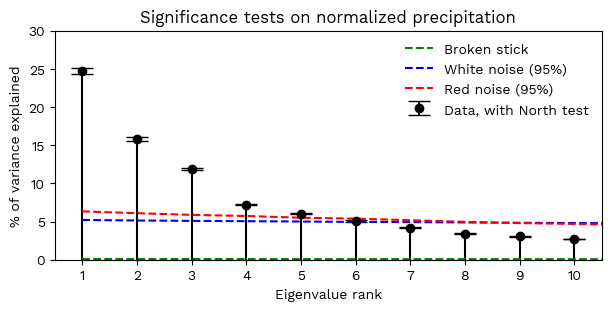

In [465]:
fig, ax = plt.subplots(figsize=(6,3), constrained_layout=True)

# Plot eigen values % of variacne explained
nEigToPlot=10
iplotShort=np.arange(1,nEigToPlot+1)
iplot=np.arange(1,len(SVar)+1)
ax.stem(iplotShort, SVar[:nEigToPlot], basefmt=" ", markerfmt='', linefmt='k-')#, label='data eigenvalues')

# North errors
ax.errorbar(iplotShort, SVar[:nEigToPlot], yerr=north_errorsVar[:nEigToPlot], capsize=8, fmt="ko", label='Data, with North test')
# plt.errorbar(iplot, SVar, yerr=north_errors, capsize=8, fmt="ko-", markerfacecolor='none', label='Data, with North test')

# Broken stick
ax.plot(iplot, bsm, linestyle="--", color="g", label='Broken stick')

ax.set_ylim([0,30])
ax.set_xlim([0.5,10.5])

# Monte Carlo approaches - red and white noise
ax.plot(iplot, SsimVarSig, linestyle="--", color="b", label="White noise (95%)") 
ax.plot(iplot, SsimVarSigR, linestyle="--", color="r", label="Red noise (95%)")
ax.legend(frameon=False)
ax.set_xlabel('Eigenvalue rank')
ax.set_ylabel('% of variance explained')
ax.set_title("Significance tests on normalized precipitation")
ax.set_xticks([1,2,3,4,5,6,7,8,9,10]);